In [23]:
import os
import numpy as np
import librosa
import yaml

# Instrument Mapping
INSTRUMENT_MAPPING = {
    "Piano": 0, "Harpsichord": 1, "Clavinet": 2, "AGuitar": 3, "EGuitar": 4, "Bass": 5,
    "Strings": 6, "Strings (continued)": 6, "Drums": 7
}

# Plugin-to-Class Mapping for [GUITAR]
ACOUSTIC_PLUGINS = {
    "/Library/Audio/Plug-Ins/Components/AGML2.component",
    "nylon_guitar.nkm", "nylon_guitar2.nkm"
}
ELECTRIC_PLUGINS = {
    "elektrik_guitar.nkm", "funk_guitar.nkm", "harmonic_guitar.nkm",
    "jazz_guitar.nkm", "jazz_guitar2.nkm", "jazz_guitar3.nkm", "jazz_guitar4.nkm",
    "rhythm_rock_guitar.nkm", "rock_guitar.nkm", "solo_guitar.nkm"
}

# Plugin-to-Class Mapping for [PIANO]
HARPSICHORD_PLUGINS = {"harpsichord.nkm"}
CLAVINET_PLUGINS = {"scarbee_clavinet_full.nkm"}

# Paths
DATASET_PATH, TIMESTAMPS_FILE, OUTPUT_DIR = "slakh2100_flac_redux/reduced_train/", "timestamps_train.txt", "labels_train/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [24]:
# Step 1: Build stem-to-class mapping
stem_to_class = {}
for track in sorted(os.listdir(DATASET_PATH)):
    metadata_file = os.path.join(DATASET_PATH, track, "metadata.yaml")
    if os.path.exists(metadata_file):
        with open(metadata_file, "r") as f:
            metadata = yaml.safe_load(f)
        for stem, info in metadata.get("stems", {}).items():
            inst_class = info.get("inst_class")
            plugin_name = info.get("plugin_name", "")

            if inst_class == "Guitar":
                if plugin_name in ACOUSTIC_PLUGINS:
                    stem_to_class[f"{track}/{stem}.flac"] = INSTRUMENT_MAPPING["AGuitar"]
                elif plugin_name in ELECTRIC_PLUGINS:
                    stem_to_class[f"{track}/{stem}.flac"] = INSTRUMENT_MAPPING["EGuitar"]
            elif inst_class == "Piano":
                if plugin_name in HARPSICHORD_PLUGINS:
                    stem_to_class[f"{track}/{stem}.flac"] = INSTRUMENT_MAPPING["Harpsichord"]
                elif plugin_name in CLAVINET_PLUGINS:
                    stem_to_class[f"{track}/{stem}.flac"] = INSTRUMENT_MAPPING["Clavinet"]
                else:
                    stem_to_class[f"{track}/{stem}.flac"] = INSTRUMENT_MAPPING["Piano"]
            elif inst_class in INSTRUMENT_MAPPING:
                stem_to_class[f"{track}/{stem}.flac"] = INSTRUMENT_MAPPING[inst_class]

# Step 2: Process timestamps and create activity matrices
activity_matrices = {}
with open(TIMESTAMPS_FILE, "r") as f:
    for line in map(str.strip, f):
        if line.startswith("Track: "):
            track = os.path.basename(line.split("Track: ")[1].replace("\\", "/"))
            mix_file = os.path.join(DATASET_PATH, track, "mix.flac")
            if os.path.exists(mix_file):
                activity_matrices[track] = np.zeros((8, int(np.floor(librosa.get_duration(path=mix_file)))), dtype=np.int8)
        elif (parts := line.split(": ")) and len(parts) == 2:
            stem_key, timestamps = f"{track}/{parts[0]}", eval(parts[1])
            if stem_key in stem_to_class:
                idx = stem_to_class[stem_key]
                for start, end in timestamps:
                    start_idx, end_idx = int(np.floor(start)), int(np.ceil(end))
                    presence = int((end - start) >= 0.1)  # 1 if duration ≥ 0.1s, else 0
                    activity_matrices[track][idx, start_idx:end_idx] = presence

# Step 3: Save matrices
for track, matrix in activity_matrices.items():
    np.save(os.path.join(OUTPUT_DIR, f"{track}.npy"), matrix)

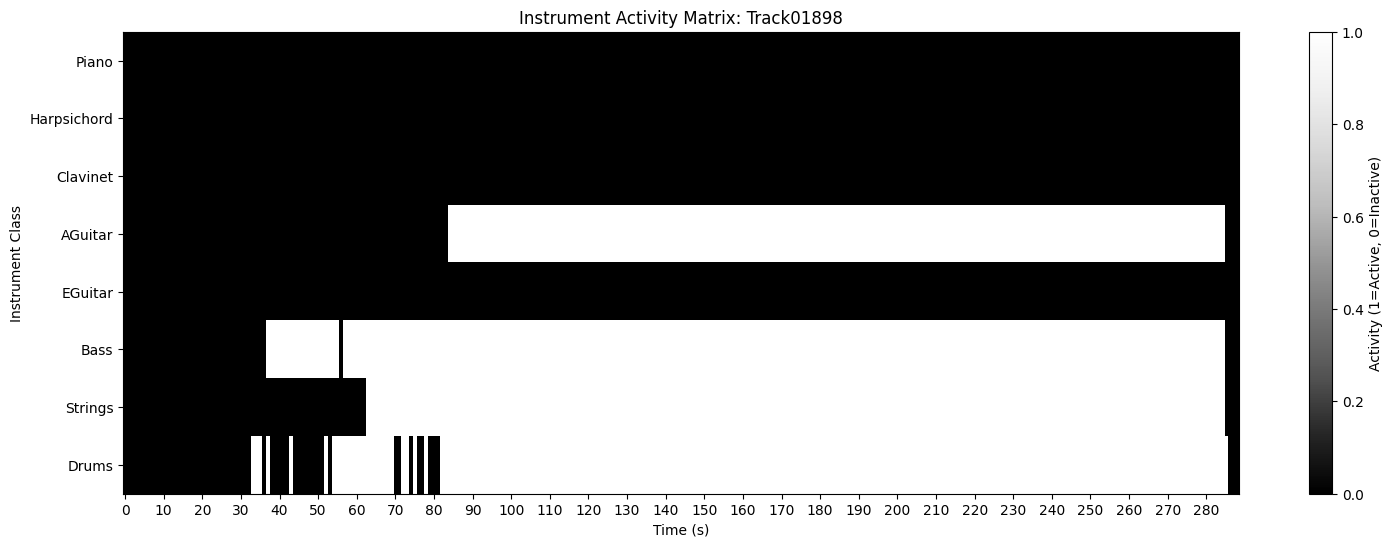

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define instrument labels for visualization
INSTRUMENT_LABELS = ["Piano", "Harpsichord", "Clavinet", "AGuitar", "EGuitar", "Bass", "Strings", "Drums"]
MATRIX_PATH = "labels_test/"

# Visualize Example
example_file = sorted(os.listdir(MATRIX_PATH))[18]  
matrix = np.load(os.path.join(MATRIX_PATH, example_file))

plt.figure(figsize=(18, 6))
plt.imshow(matrix, aspect="auto", cmap="Greys_r", interpolation="nearest")

# Labels and title
plt.yticks(range(8), INSTRUMENT_LABELS)

# Adjust xticks for 1.0-second intervals instead of 0.5
plt.xticks(range(0, matrix.shape[1], 10), np.arange(0, matrix.shape[1], 10))

plt.xlabel("Time (s)")
plt.ylabel("Instrument Class")
plt.title(f"Instrument Activity Matrix: {example_file[:-4]}")
plt.colorbar(label="Activity (1=Active, 0=Inactive)")
plt.show()